In [ ]:
# Підключення  google-диску

from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# шлях розташування датасету

mypath = '/content/gdrive/MyDrive/data'

In [ ]:
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

activities = listdir(mypath)

In [ ]:
activities

['idle', 'running', 'stairs', 'walking']

In [ ]:
# Кількість спостережень за класами

for act in activities:
  path = join(mypath, act)
  frames = listdir(path)
  print(act, ': ', len(frames))

idle :  1039
running :  3408
stairs :  165
walking :  1850


In [ ]:
frames = listdir(join(mypath, 'running'))
frame = pd.read_csv(join(join(mypath, 'running'), frames[5]))
frame

,accelerometer_X,accelerometer_Y,accelerometer_Z
0,-2.829946,11.463438,0.426168
1,2.983175,-9.102755,0.632069
2,-3.409343,7.201759,1.422156
3,-5.904101,6.981492,2.121263
4,6.919243,-11.415554,-0.560243
5,2.772486,7.776367,2.686294
6,38.709454,38.230614,-9.710882
7,11.367670,6.847417,-5.722142
8,-2.212242,7.522582,-1.924938
9,9.543288,-12.301409,4.951209


In [ ]:
# Формування єдиного датасету

all_data = []

for act in activities:
    path = join(mypath, act)
    frames = os.listdir(path)
    # Зчитування усіх файлів за один раз та додавання міток
    df_list = [pd.read_csv(join(path, f)).assign(activity=act) for f in frames if f.endswith('.csv')]
    all_data.extend(df_list)

# Об'єднання всіх даних в один DataFrame
combined_df = pd.concat(all_data, ignore_index=True)

combined_df.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity
0,-0.909797,5.281609,8.398860,idle
1,-0.521936,5.343858,8.288726,idle
2,0.028730,5.521029,8.949526,idle
3,-0.301669,4.984728,8.599973,idle
4,-0.560243,4.850653,8.288726,idle


In [ ]:
with open('data.pickle', 'wb') as file:
    pickle.dump(combined_df, file)

with open('data.pickle', 'rb') as file:
    df = pickle.load(file)

In [ ]:
df.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity
0,-0.909797,5.281609,8.398860,idle
1,-0.521936,5.343858,8.288726,idle
2,0.028730,5.521029,8.949526,idle
3,-0.301669,4.984728,8.599973,idle
4,-0.560243,4.850653,8.288726,idle


In [ ]:
grouped_df = df.groupby('activity').describe()
grouped_df

accelerometer_X                                                     \
                   count      mean       std        min       25%       50%   
activity                                                                      
idle             31170.0  0.096767  0.691892 -10.448297 -0.110133  0.234632   
running         102240.0  5.045705  9.952696 -39.188293 -1.532289  3.605668   
stairs            4950.0  0.353135  3.845949 -11.238382 -1.857900  0.483629   
walking          55500.0 -2.661943  4.648378 -26.815060 -4.855441 -2.298433   

                              accelerometer_Y            ...             \
               75%        max           count      mean  ...        75%   
activity                                                 ...              
idle      0.277727   8.135497         31170.0  2.225971  ...   5.310340   
running   9.595961  39.188293        102240.0  8.083135  ...  16.385916   
stairs    2.600103  14.164097          4950.0 -9.574353  ...  -6.301539   
walking  -0.229843  20.575770         55500.0 -9.703702  ...  -6.540959   

                    accelerometer_Z                                           \
                max           count      mean       std        min       25%   
activity                                                                       
idle       9.916783         31170.0  8.973247  1.211058  -0.296881  8.116344   
running   39.188293        102240.0  1.387356  7.004236 -39.188293 -2.873042   
stairs     4.994305          4950.0 -1.841333  5.297376 -38.086960 -3.797204   
walking   14.441825         55500.0 -1.126623  6.927679 -39.169140 -3.428497   

                                         
               50%       75%        max  
activity                                 
idle      9.749189  9.773131  21.988348  
running   0.407014  4.769250  39.188293  
stairs   -1.589750  0.292093  17.492037  
walking  -0.933739  1.561020  38.426937  

[4 rows x 24 columns]

In [ ]:
print(len(df))

193860


Підготовка даних та розрахунок часових ознак

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Функція для розрахунку часових ознак
def calculate_features(window):
    features = {
        'accelerometer_X_mean': window['accelerometer_X'].mean(),
        'accelerometer_Y_mean': window['accelerometer_Y'].mean(),
        'accelerometer_Z_mean': window['accelerometer_Z'].mean(),
        'accelerometer_X_std': window['accelerometer_X'].std(),
        'accelerometer_Y_std': window['accelerometer_Y'].std(),
        'accelerometer_Z_std': window['accelerometer_Z'].std(),
        'accelerometer_X_max': window['accelerometer_X'].max(),
        'accelerometer_Y_max': window['accelerometer_Y'].max(),
        'accelerometer_Z_max': window['accelerometer_Z'].max(),
        'accelerometer_X_min': window['accelerometer_X'].min(),
        'accelerometer_Y_min': window['accelerometer_Y'].min(),
        'accelerometer_Z_min': window['accelerometer_Z'].min(),
        'accelerometer_X_median': window['accelerometer_X'].median(),
        'accelerometer_Y_median': window['accelerometer_Y'].median(),
        'accelerometer_Z_median': window['accelerometer_Z'].median()
    }
    return pd.Series(features, index=features.keys())

# Розділення датасету на вікна та розрахунок ознак

# Встановлення розміру вікна для групування даних
window_size = 30

#Групування датасету на вікна та застосування функції calculate_features
features = df.groupby(df.index // window_size).apply(calculate_features)

# Додавання міток активності
labels = df['activity'].groupby(df.index // window_size).agg(lambda x: x.mode()[0])
features['activity'] = labels

# Підготовка набору ознак (X) та міток (y) для моделювання
X = features.drop('activity', axis=1)
y = features['activity']

# Розділення даних на навчальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ініціалізація та застосування StandardScaler для стандартизації ознак
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Побудова та навчання моделі SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Створення та навчання моделі SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Перевірка моделі на тестових даних
y_pred_svm = svm_model.predict(X_test)

# Результати моделі SVM
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       317
     running       1.00      1.00      1.00      1035
      stairs       0.74      0.70      0.72        50
     walking       0.97      0.98      0.97       537

    accuracy                           0.99      1939
   macro avg       0.93      0.92      0.92      1939
weighted avg       0.99      0.99      0.99      1939

SVM Accuracy: 0.9860752965446106


Побудова та навчання моделі випадкового лісу

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Створення та навчання моделі випадкового лісу
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Перевірка моделі на тестових даних
y_pred_rf = rf_model.predict(X_test)

# Результати моделі випадкового лісу
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       317
     running       1.00      1.00      1.00      1035
      stairs       1.00      0.96      0.98        50
     walking       1.00      1.00      1.00       537

    accuracy                           1.00      1939
   macro avg       1.00      0.99      0.99      1939
weighted avg       1.00      1.00      1.00      1939

Random Forest Accuracy: 0.998968540484786


Перевірка на перенавченість моделі

Крос-валідація для SVM

In [ ]:
from sklearn.model_selection import cross_val_score

# SVM модель
svm_scores = cross_val_score(SVC(kernel='linear'), X_train, y_train, cv=5)

print("SVM Cross-Validation Scores:", svm_scores)
print("Mean SVM CV Score:", svm_scores.mean())

SVM Cross-Validation Scores: [0.99226519 0.9878453  0.99005525 0.99004425 0.99225664]
Mean SVM CV Score: 0.9904933261624211


Крос-валідація для випадкового лісу

In [ ]:
# Модель випадкового лісу
rf_scores = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X_train, y_train, cv=5)

print("Random Forest Cross-Validation Scores:", rf_scores)
print("Mean Random Forest CV Score:", rf_scores.mean())

Random Forest Cross-Validation Scores: [0.99889503 0.99889503 0.99889503 0.99668142 0.99889381]
Mean Random Forest CV Score: 0.9984520608223733


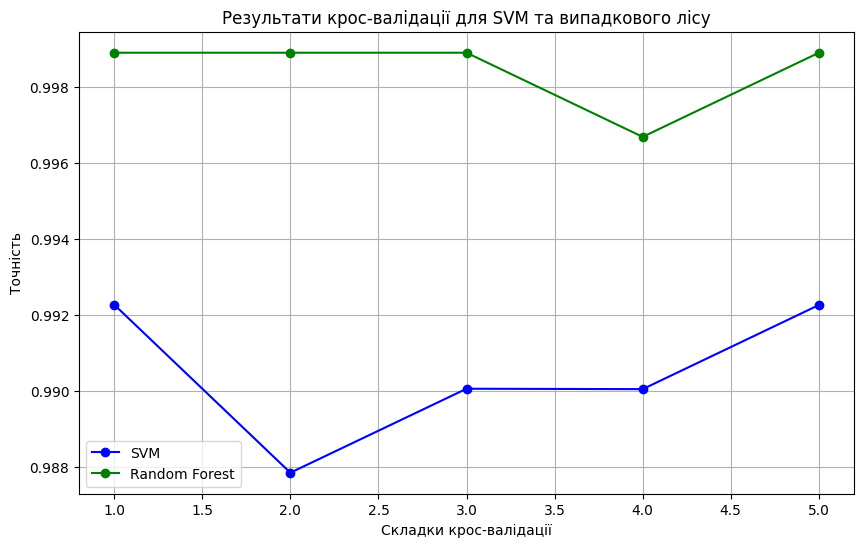

In [ ]:
# Побудова графіків для візуалізації результатів крос-валідації
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), svm_scores, marker='o', linestyle='-', color='blue', label='SVM')
plt.plot(range(1, 6), rf_scores, marker='o', linestyle='-', color='green', label='Random Forest')
plt.xlabel('Складки крос-валідації')
plt.ylabel('Точність')
plt.title('Результати крос-валідації для SVM та випадкового лісу')
plt.legend()
plt.grid(True)
plt.show()

Визначення важливості ознак для моделі випадкового лісу

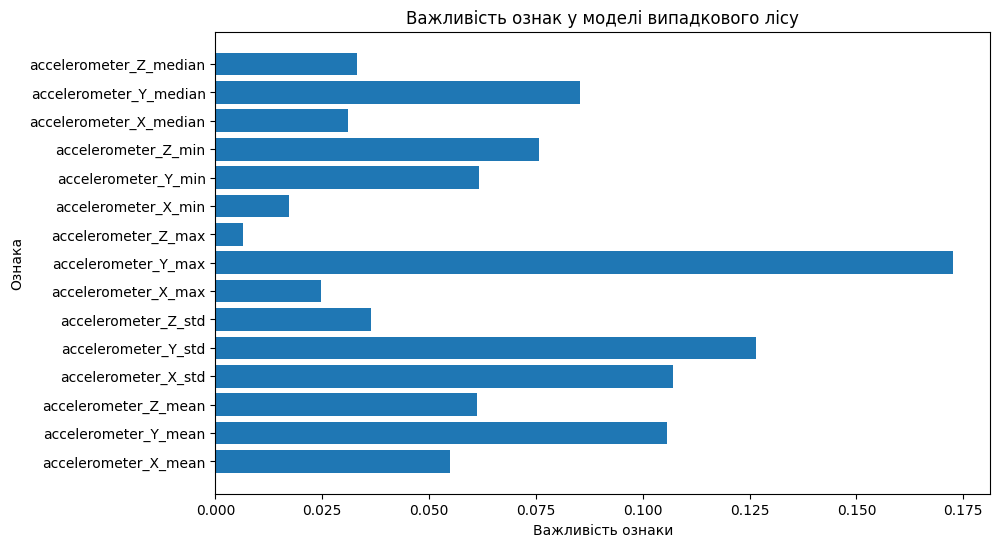

In [ ]:
# Навчаємо модель випадкового лісу
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Отримуємо важливості ознак
importances = rf_model.feature_importances_
feature_names = X.columns

# Візуалізація важливостей
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Важливість ознаки")
plt.ylabel("Ознака")
plt.title("Важливість ознак у моделі випадкового лісу")
plt.show()

Матриця помилок для SVM

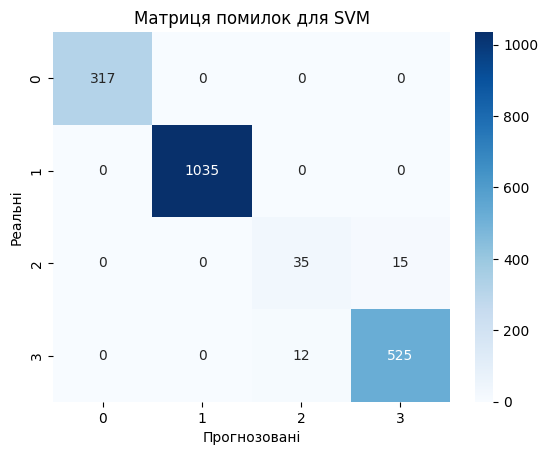

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Матриця помилок для SVM
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_mat_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Прогнозовані')
plt.ylabel('Реальні')
plt.title('Матриця помилок для SVM')
plt.show()

Матриця помилок для випадкового лісу

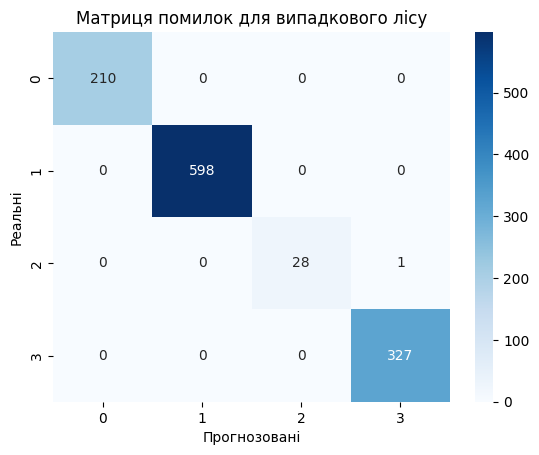

In [ ]:
# Матриця помилок для випадкового лісу
conf_mat_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_mat_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Прогнозовані')
plt.ylabel('Реальні')
plt.title('Матриця помилок для випадкового лісу')
plt.show()

Classification_report

In [ ]:
from sklearn.metrics import classification_report

# Classification report для SVM
print("Classification Report for SVM:\n")
print(classification_report(y_test, y_pred_svm))

# Classification report для випадкового лісу
print("Classification Report for Random Forest:\n")
print(classification_report(y_test, y_pred_rf))

Classification Report for SVM:

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       317
     running       1.00      1.00      1.00      1035
      stairs       0.74      0.70      0.72        50
     walking       0.97      0.98      0.97       537

    accuracy                           0.99      1939
   macro avg       0.93      0.92      0.92      1939
weighted avg       0.99      0.99      0.99      1939

Classification Report for Random Forest:

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       317
     running       1.00      1.00      1.00      1035
      stairs       1.00      0.96      0.98        50
     walking       1.00      1.00      1.00       537

    accuracy                           1.00      1939
   macro avg       1.00      0.99      0.99      1939
weighted avg       1.00      1.00      1.00      1939



**Підсумки**:

На основі результатів classification_report для обох моделей, SVM та випадкового лісу, можна зробити наступні висновки:

- **SVM (Метод опорних векторів):**

Модель має високу точність та відгук для більшості класів. Для класів 'idle', 'running' та 'walking' модель SVM показує дуже високі значення точності та відгуку, що свідчить про її ефективність у розрізненні цих активностей.
Є проблема з класифікацією класу 'stairs'. Модель має нижчу точність та відгук для класу 'stairs' (0.74 та 0.70 відповідно), на що може впливати недостатня кількість даних для цього класу або можливо на те, що характеристики рухів 'stairs' складніше відрізнити від інших активностей.
Загальна точність моделі становить 0.99, що є високим показником, але варто звернути увагу на балансування класів, особливо для 'stairs'.

- **Випадковий ліс (Random Forest):**

Модель випадкового лісу демонструє високу точність та відгук по всіх класах, включаючи клас 'stairs'.
Загальна точність моделі випадкового лісу є ідеальною (1.00), а також високі макро- та зважені середні значення, що вказує на дуже добру збалансованість моделі.

Загальні висновки:

Модель випадкового лісу виявилася більш точною та збалансованою у порівнянні з моделлю SVM, особливо в класифікації менш представлених класів, таких як 'stairs'.
Для подальшого поліпшення моделі SVM можливо буде корисним збільшення кількості даних для класу 'stairs' або використання технік, які спеціально спрямовані на поліпшення класифікації менш представлених класів.

Порівняння результатів роботи обох алгоритмів на різних фічах

In [ ]:
# Функція для вибору ознак

def select_features(df, feature_set):
    selected_features = df[feature_set]
    return selected_features

In [ ]:
# Створення різних наборів ознак

feature_sets = {
    "mean_features": ['accelerometer_X_mean', 'accelerometer_Y_mean', 'accelerometer_Z_mean'],
    "std_features": ['accelerometer_X_std', 'accelerometer_Y_std', 'accelerometer_Z_std'],
    "max_features": ['accelerometer_X_max', 'accelerometer_Y_max', 'accelerometer_Z_max'],
    "min_features": ['accelerometer_X_min', 'accelerometer_Y_min', 'accelerometer_Z_min'],
    "mean_std_features": ['accelerometer_X_mean', 'accelerometer_Y_mean', 'accelerometer_Z_mean', 'accelerometer_X_std', 'accelerometer_Y_std', 'accelerometer_Z_std'],
    "all_features": list(X.columns)
}

In [ ]:
# Порівння моделей на різних фічах

for name, feature_set in feature_sets.items():
    print(f"Testing feature set: {name}")

    # Вибір ознак
    X_selected = select_features(features, feature_set)

    # Розділення даних на тренувальні та тестові набори
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

    # Стандартизація даних
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Тренування та тестування SVM
    svm_model = SVC(kernel='linear')
    svm_model.fit(X_train_scaled, y_train)
    y_pred_svm = svm_model.predict(X_test_scaled)
    print("SVM Classification Report:")
    print(classification_report(y_test, y_pred_svm, zero_division=0))

    # Тренування та тестування випадкового лісу
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    y_pred_rf = rf_model.predict(X_test_scaled)
    print("Random Forest Classification Report:")
    print(classification_report(y_test, y_pred_rf, zero_division=0))

Testing feature set: mean_features
SVM Classification Report:
              precision    recall  f1-score   support

        idle       0.99      1.00      0.99       317
     running       1.00      1.00      1.00      1035
      stairs       0.00      0.00      0.00        50
     walking       0.91      1.00      0.96       537

    accuracy                           0.97      1939
   macro avg       0.73      0.75      0.74      1939
weighted avg       0.95      0.97      0.96      1939

Random Forest Classification Report:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       317
     running       1.00      1.00      1.00      1035
      stairs       0.93      0.54      0.68        50
     walking       0.96      1.00      0.98       537

    accuracy                           0.99      1939
   macro avg       0.97      0.88      0.92      1939
weighted avg       0.99      0.99      0.99      1939

Testing feature set: std_featur

**Висновки по результатам роботи алгоритму на різних фічах**

Випадковий ліс: Показує стабільно високу продуктивність у всіх тестах, з точністю та відгуком близькими до 1.00 для більшості класів у всіх наборах ознак.

SVM: Чутливіша до вибору ознак. Наприклад, з mean_features для класу 'stairs' точність та відгук - 0.00, порівняно з all_features, де точність - 0.74, відгук - 0.70.

Якщо дивитися детально по кожному набору ознак можна побачити:

*mean_features*:

SVM: Проблеми з класифікацією 'stairs' (точність та відгук - 0.00).
Випадковий ліс: Кращі результати для 'stairs' (точність - 0.93, відгук - 0.54).

*std_features*:

SVM: Не змогла класифікувати 'stairs' (точність та відгук - 0.00).
Випадковий ліс: Точність для 'stairs' - 0.68, відгук - 0.42.

*max_features*:

SVM: Зниження загальної точності до 0.90.
Випадковий ліс: Високі результати, точність для 'stairs' - 0.98, відгук - 0.94.

*min_features*:

SVM: Загальна точність знизилась до 0.86.
Випадковий ліс: Загальна точність - 0.99, точність для 'stairs' - 0.98, відгук - 0.90.

*mean_std_features*:

SVM: Покращення для 'stairs' (точність - 0.75, відгук - 0.60).
Випадковий ліс: Висока загальна точність - 1.00.
all_features:

SVM: Найкращі результати, особливо для 'stairs' (точність - 0.74, відгук - 0.70).

SVM потребує більш ретельного вибору ознак для підвищення продуктивності, особливо для важко класифікованих класів як 'stairs'.
Випадковий ліс виявився ефективнішим при різних наборах ознак, демонструючи високу точність та відгук навіть у більш обмежених умовах.